# Download the Data and BERT model

**About the Data**

It contains 50,000 reviews from the Internet Movie Database (IMDB) split evenly into 25,000 reviews for training and 25,000 reviews for testing. The task is binary classification: each review is labeled as either positive (1) or negative (0) based on the sentiment expressed by the reviewer.italicized text

**About the Task**

Here will be training a transformer model on the IMDB dataset for sentiment analysis, the process typically involves:

**Preprocessing the Data**: *Cleaning and preparing the text data, including tokenization (converting sentences into tokens or words), and possibly removing stopwords (common words that do not contribute much meaning)*.

**Vectorization**: *Transforming text data into numerical form so that machine learning algorithms can process it. This could involve embedding techniques like Word2Vec, GloVe, or, as in our case with BERT, utilizing pre-trained contextual embeddings*.

**Model Training**: *Using the processed data to train a machine learning model (such as BERT in the provided example) to predict the sentiment of reviews. The model learns to associate patterns in the text with the corresponding sentiments through exposure to a large number of labeled examples*.

**Evaluation**: *Assessing the model's performance on a separate test set not seen during training to ensure it has learned to generalize well to new, unseen data*.

### *Note on Hardware Acceleration* ###

To check what hardware acceleration you're using in Colab, you can go to Edit > Notebook settings or Runtime > Change runtime type and select the hardware accelerator.

CPU: Training on a CPU is the slowest option and might take several hours for a task like fine-tuning BERT on the IMDB dataset. It's not uncommon for the training to take over 10 hours or more, depending on the specific CPU and model complexity.

GPU: Using a GPU will significantly speed up the training process. For a task like this, training might take 1 to 2 hours on a Tesla K80 (a common GPU in the free version of Colab) and could be faster on more advanced GPUs like the Tesla P100 or V100 often available in Colab Pro.

TPU: TPUs can offer even faster training times due to their high throughput for matrix operations, which are common in deep learning. Training the same task on a TPU might take under an hour. However, configuring TPUs can be more complex, and not all PyTorch models or training routines are directly compatible with TPUs without modification.

In [1]:
# BERT Fine-Tuning Walkthrough for UCLAx Machine Learning in Python
# This notebook shows how to fine-tune BERT for sentiment analysis using the IMDB dataset.

# Install required
!pip install transformers[torch]
!pip install datasets

from datasets import load_dataset
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments

# Load the IMDB dataset
dataset = load_dataset("imdb")

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the dataset
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=512)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Load the BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Prepare the Model

In [23]:
from transformers import TrainerCallback

# we want to record the performance during training, so we'll use a callback. A callback is a way of supplying a set of instructions (code) and storing/reporting the results
# this works very similar to sklearn where we instantiate an estimator (dervied form the BaseEstimator super class) and call the fit method, which populates instance variables
# with values that are relevent to the fit. An example might be the coefficients that a LinearRegressor estimator has estimated from a set of training data

class MetricsCallback(TrainerCallback):
    """A callback to capture metrics after training steps and evaluation."""
    def __init__(self):
        super().__init__()
        self.training_logs = []  # To store training metrics
        self.eval_logs = []  # To store evaluation metrics

    def on_log(self, args, state, control, logs=None, **kwargs):
        # Capture training metrics. Note: This captures every logging step, adjust as necessary.
        if logs is not None:
            self.training_logs.append(logs['loss'])

    def on_evaluate(self, args, state, control, metrics=None, **kwargs):
        # Capture evaluation metrics.
        if metrics is not None:
            self.eval_logs.append(metrics)

# Prepare Evaluation Metrics

In [3]:
from datasets import load_metric

# Load the accuracy metric function from the datasets library
accuracy_metric = load_metric("accuracy")

def compute_metrics(pred):
    """Compute the accuracy of predictions.

    Args:
        pred (transformers.trainer_utils.EvalPrediction): The predictions and labels.

    Returns:
        dict: A dictionary with the accuracy score.
    """
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    # Calculate accuracy using the datasets library's metric
    acc = accuracy_metric.compute(predictions=preds, references=labels)
    return acc


<ipython-input-3-25244b95a8f6>:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  accuracy_metric = load_metric("accuracy")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


# Train the Model


Batch Size: This is the number of samples processed before the model is updated

Epochs: One epoch is completed when every sample in the dataset has been used once for training.
Warmup Steps: A part of the learning rate scheduler where the learning rate increases gradually up to the initial learning rate. It doesn't change the total number of steps.

In [ ]:

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    eval_steps=10,
    logging_steps=10,
)
# Here we instantiate our callback
metrics_callback = MetricsCallback()

# instantiate a Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['test'],
    compute_metrics=compute_metrics,  # add the metrics function, we're computing the accuracy.
    callbacks=[metrics_callback]
)

# Train
# You'll notice a progress bar. The total number of steps is computed for our case as follows: (25,000 / 8) * 3 = 9,375
# on a free T4 GPU this will take about 2 hours.

trainer.train()

# Evaluate the Model

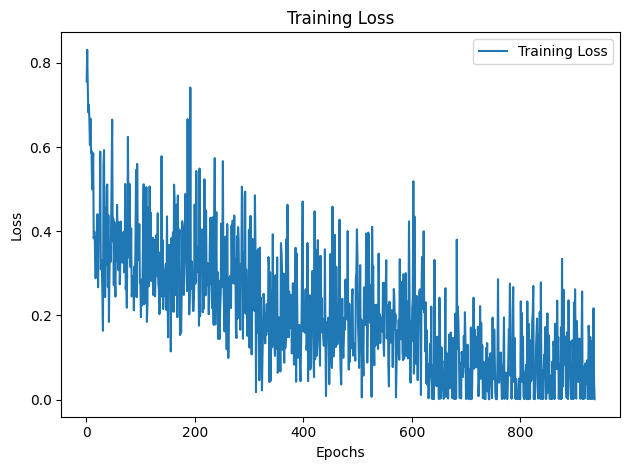

In [9]:
import matplotlib.pyplot as plt

def plot_metrics(train_loss_set):
    epochs = range(1, len(train_loss_set) + 1)
    plt.plot(epochs, train_loss_set, label='Training Loss')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_metrics(metrics_callback.train_loss_set)


In [10]:
eval_results = trainer.evaluate()
print(eval_results)

{'eval_loss': 0.31298261880874634, 'eval_accuracy': 0.93868, 'eval_runtime': 805.7926, 'eval_samples_per_second': 31.025, 'eval_steps_per_second': 3.878, 'epoch': 3.0}
